In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import torch.optim as optim
from albumentations import (GaussianBlur, CropNonEmptyMaskIfExists, Resize,
                            ShiftScaleRotate, VerticalFlip, HorizontalFlip, Cutout,
                            Compose, OneOf
                           )
from hyperdash import Experiment
import tifffile as tiff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from util.dataset_def import Panda
import torch.nn.functional as F
import tqdm
import time

%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']='2'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
root = '/mnt/wamri/panda/'

In [5]:
train_df = pd.read_csv(os.path.join(root, 'train.csv'))
train_df, val_df = train_test_split(train_df, train_size=0.8, random_state=34)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=34)

In [6]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [7]:
w = h = 256
train_trans = Compose([OneOf([Resize(height=h, width=w), 
                              CropNonEmptyMaskIfExists(height=h, width=w, ignore_values=[0,1])], p=1),
                       VerticalFlip(), HorizontalFlip(), Cutout(num_holes=8, max_h_size=15, max_w_size=15, p=0.3)
                      ])
vt_trans = Compose([Resize(height=h, width=w)])
train_ds = Panda(train_df, train_trans)
val_ds = Panda(val_df, vt_trans)
test_ds = Panda(test_df, vt_trans)

In [8]:
x = train_ds[2]

Reading
Transforms


In [9]:
x['id']

'de06480e9ad90fd6fbb3b2496eb6d35b'

In [10]:
x['isup']

tensor([0.])

In [11]:
x['prov']

'radboud'

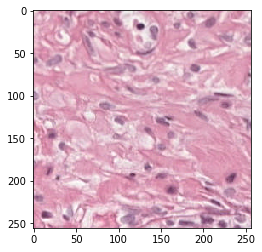

In [12]:
plt.imshow(x['image'].permute(1,2,0).numpy().astype('uint8'))

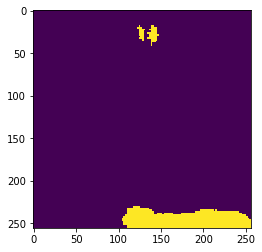

In [13]:
plt.imshow(x['mask'])

In [14]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=4)

In [15]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 6)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
optimizer = optim.Adam(model.parameters(), 1e-4)
sched = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, 
                                    max_lr=0.1, scale_mode='triangular',
                                    step_size_up=2010//2, cycle_momentum=False)

In [17]:
def train(model, optimizer, train_dl, criterion, sched=None):
    model.train()
    total = 0
    sum_loss = 0
    for batch in tqdm.tqdm(train_dl):
        x = batch['image'].to(device)
        y = batch['isup'].to(device)
        batch_size = x.shape[0]
        loss = 0
        yhat = model(x)
        loss = criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if sched: sched.step()
        total += batch_size
        sum_loss += batch_size*(loss.item())
        
    return sum_loss/total

In [18]:
def val(model, valid_dl, criterion, metric):
    model.eval()
    total = 0
    sum_loss = 0
    y_hat = []
    ys = []
    for batch in tqdm.tqdm(valid_dl):
        x = batch['image'].to(device)
        y = batch['isup']
        batch_size = x.shape[0]
        yhat = model(x)
        loss = criterion(yhat, y)
        sum_loss += batch_size*(loss.item())
        total += batch_size
        y_hat.append(torch.argmax(yhat.data, 1))
        ys.append(y)
    
    y_hat = np.vstack(y_hat)
    ys = np.vstack(ys)
    m = metric(ys, y_hat)
    return sum_loss/total, m

In [19]:
def epochs(model, optimizer, train_dl, val_dl, criterion, metric, name, sched=None, n=30):
    exp = Experiment(name)
    t_losses = []
    v_losses = []
    e = [i for i in range(1, n+1)]
    max_m = -np.inf
    for i in range(1, n+1):
        start = time.time()
        t_loss = train(model, optimizer, train_dl, criterion, sched)
        v_loss, m = val(model, val_dl, criterion, metric)
        t_losses.append(t_loss)
        v_losses.append(v_loss)
        if m > max_m: # Save model at best metric
            max_m = m
            torch.save(model.state_dict(), os.path.join('models',name+f'_{m:.2f}'.replace('.','_')))
            
        exp.metric("Training Loss", training_loss[-1])
        exp.metric("Val Metric", val_acc[-1])
        exp.metric("Val Loss", val_loss[-1])
        
        print(f'Epoch {i} {time.time()-start} seconds: {m} quadratic kappa')
        plt.plot(x=e, y=t_losses, color='blue')
        plt.plot(x=e, y=v_losses, color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')
        plt.show()
        print()

# REALLY SLOW

In [20]:
val(model, val_dl, F.cross_entropy, cohen_kappa_score)

  0%|          | 0/9 [00:00<?, ?it/s]

Reading
Reading
Transforms
Transforms
Reading
Reading
Transforms
Transforms
Reading
Reading
Reading
Transforms
Transforms
Reading
Transforms
Transforms
Reading
Reading
Transforms
Transforms
Reading
Transforms
Reading
Reading
Reading
Transforms
Transforms
Reading
Transforms
Transforms
Reading
Reading
Transforms
Reading
Transforms
Transforms
Reading
Transforms
Reading
Reading
Transforms
Transforms
Reading
Transforms
Reading
Reading
Transforms
Transforms
Reading
Reading
Reading
Transforms
Transforms
Transforms
Reading
Transforms
Reading
Transforms
Reading
Transforms
Reading
Reading
Transforms
Transforms
Reading
Reading
Reading
Transforms
Transforms
Reading
Transforms
Reading
Transforms
Transforms
Reading
Reading
Transforms
Transforms
Reading
Transforms
Reading
Transforms
Reading
Transforms
Reading
Reading
Reading
Transforms
Reading
Transforms
Reading
Transforms
Transforms
Transforms
Reading
Transforms
Reading
Transforms
Reading
Transforms
Reading
Reading
Reading
Transforms
Transforms
Tran

Transforms
Reading
Reading
Transforms
Transforms
Reading
Transforms
Reading
Reading
Transforms
Reading
Transforms
Transforms
Reading
Transforms
Reading
Reading
Transforms
Transforms
Reading
Reading
Transforms
Reading
Transforms
Transforms
Reading
Reading
Transforms
Reading
Transforms
Transforms
Reading
Reading
Transforms
Transforms
Reading
Reading
Transforms
Transforms
Reading
Transforms
Reading
Reading
Transforms
Reading
Reading
Transforms
Transforms
Transforms
Reading
Reading
Transforms
Transforms
Reading
Transforms
Reading
Reading
Transforms
Reading
Reading
Transforms
Transforms
Reading
Transforms
Transforms
Reading
Transforms
Reading
Reading
Reading
Transforms
Transforms
Transforms
Reading
Transforms
Reading
Transforms
Reading
Reading
Transforms
Reading
Reading
Transforms
Transforms
Reading
Reading
Transforms
Transforms
Transforms
Reading
Transforms
Reading
Reading
Reading
Transforms
Transforms
Transforms
Reading
Transforms
Reading
Reading
Transforms
Transforms
Reading
Transforms
R

  0%|          | 0/9 [06:06<?, ?it/s]


RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'target' in call to _thnn_nll_loss_forward

In [ ]:
epochs(model, optimizer, train_dl, val_dl, F.cross_entropy, cohen_kappa_score, 'resnet50', sched)

  0%|          | 0/67 [00:00<?, ?it/s]